In [1]:
# Import necessary modules
import math
import time
import numpy as np
import scipy.io as sio
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.layers import Input, Dense, BatchNormalization, Reshape, Conv2D, add, LeakyReLU
from keras.models import Model, model_from_json
from keras.callbacks import TensorBoard, Callback
tf.compat.v1.reset_default_graph()
#tf.reset_default_graph()

In [2]:
# Set image and network params
envir = 'indoor' #'indoor' or 'outdoor'

# Image params
img_height = 32
img_width = 32
img_channels = 2 
img_total = img_height*img_width*img_channels

# Network params
residual_num = 2
encoded_dim = 512  #compress rate=1/4->dim.=512, compress rate=1/16->dim.=128, compress rate=1/32->dim.=64, compress rate=1/64->dim.=32

In [3]:
# Load pre-trained model and weights
file = 'CsiNet_'+(envir)+'_dim'+str(encoded_dim)

# Load json and create model
outfile = "./files_06_channel/saved_model/model_%s.json"%file
json_file = open(outfile, 'r')
loaded_model_json = json_file.read()
json_file.close()
autoencoder = model_from_json(loaded_model_json)

# Load weights outto new model
outfile = "./files_06_channel/saved_model/model_%s.h5"%file
autoencoder.load_weights(outfile)

2022-09-06 14:53:50.162700: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-06 14:53:50.203603: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-06 14:53:50.203980: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-06 14:53:50.205608: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [4]:
# Load dataset
if envir == 'indoor':
    mat = sio.loadmat('./files_06_channel/data/DATA_Htestin.mat')
    x_test = mat['HT'] # array

elif envir == 'outdoor':
    mat = sio.loadmat('./files_06_channel/data/DATA_Htestout.mat')
    x_test = mat['HT'] # array

x_test = x_test.astype('float32')
x_test = np.reshape(x_test, (len(x_test), img_channels, img_height, img_width))  # adapt this if using `channels_first` image data format

In [5]:
# Testing data
tStart = time.time()
x_hat = autoencoder.predict(x_test)
tEnd = time.time()
print ("It cost %f sec" % ((tEnd - tStart)/x_test.shape[0]))

2022-09-06 14:53:58.168381: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101


625/625 [==============================] - 4s 4ms/step
It cost 0.000217 sec


In [6]:
# Calcaulating the NMSE and rho

# Load data with 125 (subcarriers) * 32 (antenna) to calculate rho
if envir == 'indoor':
    mat = sio.loadmat('./files_06_channel/data/DATA_HtestFin_all.mat')
    X_test = mat['HF_all']# array

elif envir == 'outdoor':
    mat = sio.loadmat('./files_06_channel/data/DATA_HtestFout_all.mat')
    X_test = mat['HF_all']# array

X_test = np.reshape(X_test, (len(X_test), img_height, 125))
x_test_real = np.reshape(x_test[:, 0, :, :], (len(x_test), -1))
x_test_imag = np.reshape(x_test[:, 1, :, :], (len(x_test), -1))
x_test_C = x_test_real-0.5 + 1j*(x_test_imag-0.5)
x_hat_real = np.reshape(x_hat[:, 0, :, :], (len(x_hat), -1))
x_hat_imag = np.reshape(x_hat[:, 1, :, :], (len(x_hat), -1))
x_hat_C = x_hat_real-0.5 + 1j*(x_hat_imag-0.5)
x_hat_F = np.reshape(x_hat_C, (len(x_hat_C), img_height, img_width))
X_hat = np.fft.fft(np.concatenate((x_hat_F, np.zeros((len(x_hat_C), img_height, 257-img_width))), axis=2), axis=2)
X_hat = X_hat[:, :, 0:125]

n1 = np.sqrt(np.sum(np.conj(X_test)*X_test, axis=1))
n1 = n1.astype('float64')
n2 = np.sqrt(np.sum(np.conj(X_hat)*X_hat, axis=1))
n2 = n2.astype('float64')
aa = abs(np.sum(np.conj(X_test)*X_hat, axis=1))
rho = np.mean(aa/(n1*n2), axis=1)
X_hat = np.reshape(X_hat, (len(X_hat), -1))
X_test = np.reshape(X_test, (len(X_test), -1))
power = np.sum(abs(x_test_C)**2, axis=1)
power_d = np.sum(abs(X_hat)**2, axis=1)
mse = np.sum(abs(x_test_C-x_hat_C)**2, axis=1)

/tmp/ipykernel_15621/2411451901.py:24: ComplexWarning: Casting complex values to real discards the imaginary part
  n1 = n1.astype('float64')
/tmp/ipykernel_15621/2411451901.py:26: ComplexWarning: Casting complex values to real discards the imaginary part
  n2 = n2.astype('float64')


In [7]:
print("In "+envir+" environment")
print("When dimension is", encoded_dim)
print("NMSE is ", 10*math.log10(np.mean(mse/power)))
print("Correlation is ", np.mean(rho))

In indoor environment
When dimension is 512
NMSE is  -17.363400049721832
Correlation is  0.9882019190837945


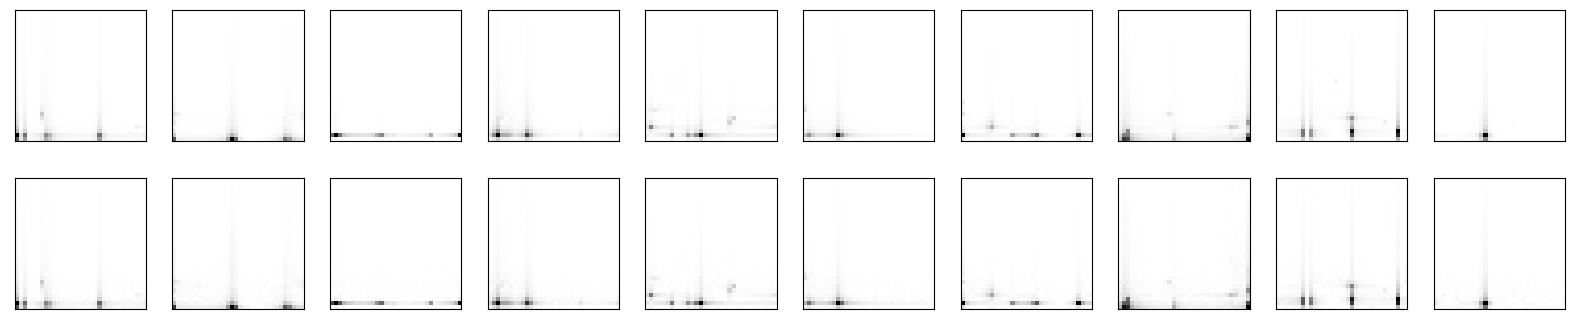

In [8]:
# Display the original and reconstructed pseudo-gray plots of the strength of H
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1 )
    x_testplo = abs(x_test[i, 0, :, :]-0.5 + 1j*(x_test[i, 1, :, :]-0.5))
    plt.imshow(np.max(np.max(x_testplo))-x_testplo.T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.invert_yaxis()
    
    # display reconstructed
    ax = plt.subplot(2, n, i + 1 + n)
    decoded_imgsplo = abs(x_hat[i, 0, :, :]-0.5 
                          + 1j*(x_hat[i, 1, :, :]-0.5))
    plt.imshow(np.max(np.max(decoded_imgsplo))-decoded_imgsplo.T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.invert_yaxis()
plt.show()